# Dimension Reduction

In [1]:
# 유방암 데이터 셋
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

cancer = load_breast_cancer()

# y=0(Malignant:악성 종양), y=1(Benign:양성 종양)
cancer_X, cancer_y= cancer.data, cancer['target']
train_X, test_X, train_y, test_y = train_test_split(cancer_X, cancer_y, test_size=0.1, random_state=10) # train 데이터셋과 test 데이터셋으로 나눔
print(f"전체 검사자 수: {len(cancer_X)}")
print(f"Train dataset에 사용되는 검사자 수: {len(train_X)}")
print(f"Test dataset에 사용되는 검사자 수: {len(test_X)}")
cancer_df = pd.DataFrame(cancer_X, columns=cancer['feature_names'])
cancer_df.head()

전체 검사자 수: 569
Train dataset에 사용되는 검사자 수: 512
Test dataset에 사용되는 검사자 수: 57


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### PCA

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.metrics import accuracy_score
from collections import Counter

color_dict = {0: 'red', 1: 'blue', 2:'red', 3:'blue'}
target_dict = {0: 'malignant_train', 1: 'benign_train', 2: 'malignant_test', 3:'benign_test'}

scaler = StandardScaler().fit(train_X)
train_X_ = scaler.transform(train_X)
train_df = pd.DataFrame(train_X_, columns=cancer["feature_names"])

# train set 차원 축소
pca = PCA(n_components=2)
pca = pca.fit(train_df)
pc = pca.transform(train_df)

In [3]:
# test set 차원 축소
test_X_ = scaler.transform(test_X)
test_df = pd.DataFrame(test_X_, columns=cancer["feature_names"])
pc_test = pca.transform(test_df)


In [4]:
# PCA를 적용한 train data의 classifier 훈련
clf = svm.SVC(kernel = 'rbf', gamma=0.5, C=0.8)
clf.fit(pc, train_y)

# PCA를 적용하지 않은 original data의 SVM 훈련
clf_orig = svm.SVC(kernel = 'rbf', gamma=0.5, C=0.8)
clf_orig.fit(train_df, train_y)

SVC(C=0.8, gamma=0.5)

PCA 분석을 사용한 Test dataset accuracy: 52명/57명 => 0.912
PCA를 적용하지 않은 Test dataset accuracy: 44명/57명 => 0.772


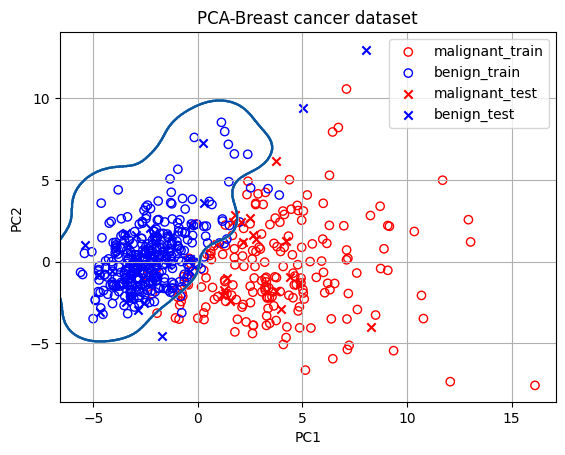

In [5]:
# 시각화

import matplotlib.pyplot as plt

def plot_decision_boundary(X, clf, ax): 
    h = .02  # step size in the mesh
    # create a mesh to plot in
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contour(xx, yy, Z, cmap='Blues')

# 캔버스 도식
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# malignant와 benign의 SVM decision boundary 그리기
plot_decision_boundary(pc, clf, ax)

#Train data
for cluster in range(2):
    sub_cancer_points = pc[train_y == cluster]
    ax.scatter(sub_cancer_points[:, 0], sub_cancer_points[:, 1], edgecolor=color_dict[cluster], c='none', label=target_dict[cluster])
    
#Test data
for cluster in range(2):
    sub_cancer_points = pc_test[test_y == cluster]
    ax.scatter(sub_cancer_points[:, 0], sub_cancer_points[:, 1], marker= 'x', c=color_dict[cluster+2], label=target_dict[cluster+2])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('PCA-Breast cancer dataset')
ax.legend()
ax.grid()

# Scoring
pca_test_accuracy_dict = Counter(clf.predict(pc_test) == test_y)
orig_test_accuracy_dict = Counter(clf_orig.predict(test_df) == test_y)

print("PCA 분석을 사용한 Test dataset accuracy: {}명/{}명 => {:.3f}".format(pca_test_accuracy_dict[True], sum(pca_test_accuracy_dict.values()), clf.score(pc_test, test_y)))
print("PCA를 적용하지 않은 Test dataset accuracy: {}명/{}명 => {:.3f}".format(orig_test_accuracy_dict[True], sum(orig_test_accuracy_dict.values()), clf_orig.score(test_df, test_y)))

### T_SNE(T-Sochastic Neighbor Embedding)
* 방사형적, 비선형적인 분포에서는 많은 정보량을 담기 위한 주성분으로 잡을 선형적인 축을 찾기 어렵다.
* T-SNE는 기존 차원의 공간에서의 거리를 저차원에서도 표현할 수 있는 차원 축소 방법이다.(기존 차원에서 가까운 데이터 포인트들을 차원 축소된 공간에서도 가깝게 유지)
* PCA는 데이터가 갖는 물리량의 정보를 보존하는데 집중한다면 T-SNE는 데이터들 간의 상대적인 거리를 보존하는데 주력한다.

In [9]:
from scipy.io import arff
import pandas as pd
import os

path = os.getcwd() + "/data/mnist_784.arff"
mnist = arff.loadarff(path)

In [18]:
# DataFrame
df = pd.DataFrame(mnist[0])
df["label"] = df["class"].apply(lambda i: str(i)[2])

n_image = mnist[0].shape[0]
pixel_columns = list(df.columns[:-2])

In [19]:
# random sampling

np.random.seed(30)

rndperm = np.random.permutation(n_image)

n_image_sample = 10_000
random_idx = rndperm[:n_image_sample]
df_subset = df.loc[random_idx, :].copy()
df_subset.shape

(10000, 786)

<Figure size 640x480 with 0 Axes>

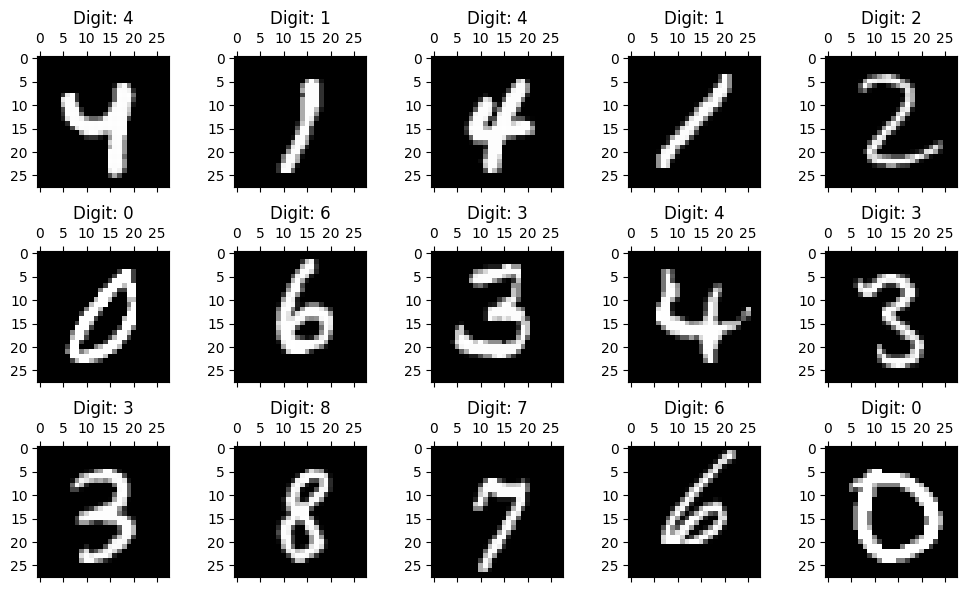

In [21]:
# 데이터셋 시각화

import seaborn as sns
import matplotlib.pyplot as plt

plt.gray()
fig = plt.figure(figsize=(10, 6))
n_img_sample = 15
width, height = 28, 28

for i in range(n_img_sample):
    row = df_subset.iloc[i]
    ax = fig.add_subplot(3, 5, i+1, title=f"Digit: {row["label"]}")
    ax.matshow(row[pixel_columns]
                .values.reshape(width, height)
                .astype(float))

plt.tight_layout()
plt.show()

### PCA를 이용한 MNIST 차원축소

In [23]:
from sklearn.decomposition import PCA

n_dimension = 2
pca = PCA(n_components=n_dimension)

pca_result = pca.fit_transform(df_subset[pixel_columns].values)
df_subset["pca-one"] = pca_result[:, 0]
df_subset["pca-two"] = pca_result[:, 1]

print(f"pca_result의 shape: {pca_result.shape}")

pca_result의 shape: (10000, 2)


principal component 별 보존 정보량 확인

In [24]:
print(f"pca-1{round(pca.explained_variance_ratio_[0], 3) * 100}%")
print(f"pca-1{round(pca.explained_variance_ratio_[1], 3) * 100}%")

pca-19.6%
pca-17.3%


784차원을 2차원으로 축소했을 때, 정보량이 전체의 37% 정도 남는다.

<Axes: xlabel='pca-one', ylabel='pca-two'>

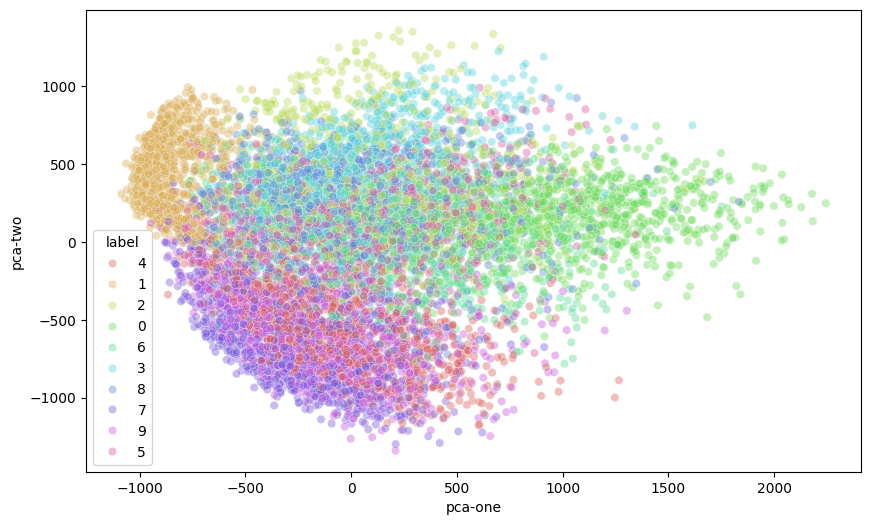

In [25]:
# PCA 차원 축소 시각화

fig = plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_subset, x="pca-one", y="pca-two",
                hue="label", palette=sns.color_palette("hls", 10),
                legend="full",
                alpha=0.4)


### T-SNE를 이용한 차원 축소

In [27]:
from sklearn.manifold import TSNE

print(f"df_subset의 shape: {df_subset.shape}")

data_subset = df_subset[pixel_columns].values
n_dimension = 2
tsne = TSNE(n_components=n_dimension)
tsne_results = tsne.fit_transform(X=data_subset)

print(f"tsne_results의 shape: {tsne_results.shape}")

df_subset의 shape: (10000, 788)
tsne_results의 shape: (10000, 2)


<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

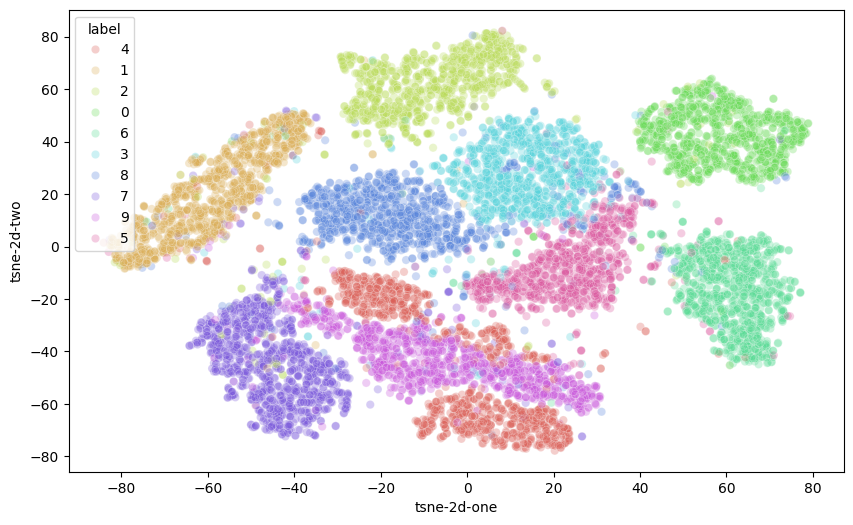

In [30]:
# 컬럼에 추가

df_subset["tsne-2d-one"] = tsne_results[:, 0]
df_subset["tsne-2d-two"] = tsne_results[:, 1]

# 시각화

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_subset, x="tsne-2d-one", y="tsne-2d-two", hue="label",
                palette=sns.color_palette("hls", 10),
                legend="full", alpha=0.3)


* T_SNE는 기존 차원의 공간에서 가까운점들은, 차원 축소된 공간에서도 여전히 가깝게 유지되는 것을 볼 수 있다. 같은 숫자의 이미지가 유사한 거리에 놓이는 것을 확인할 수 있다.

* PCA를 통해 차원축소를 하면서 발생하는 정보 손실은 두 점 사이의 거리라는 중요한 정보가 손실되는 측면이 있다.